# Assignment 10 (Based on Lab9 - Spatial Data Analysis)
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [7]:
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import os
from fiona.crs import from_epsg
import statsmodels.api as sm
import shapely
import pysal as ps
import seaborn as sns
from matplotlib import colors
%matplotlib inline

In [8]:
# Altered for PUI Data Class Format 

def get_data():
    '''
    This function downloads the Homework 10 datasets as provided and keeps them in the working homework directory
    due to kernel compatability issues.
    '''
    
    url_Base = 'https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data'
    
    # Download Data from Github
    !curl -O "{url_Base}/ACS_CT2010.csv"
    !curl -O "{url_Base}/CitiBike_monthly_byStation.csv"
    !curl -O "{url_Base}/Station_id.csv"
    !curl -O "{url_Base}/CT_Shape/R10_BoroCT2010.csv"
    !curl -O "{url_Base}/CT_Shape/ct_shape.cpg"
    !curl -O "{url_Base}/CT_Shape/ct_shape.dbf"
    !curl -O "{url_Base}/CT_Shape/ct_shape.prj"
    !curl -O "{url_Base}/CT_Shape/ct_shape.shp"
    !curl -O "{url_Base}/CT_Shape/ct_shape.shx"  
      
get_data()    



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2405k  100 2405k    0     0  6174k      0 --:--:-- --:--:-- --:--:-- 9468k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 77643  100 77643    0     0   355k      0 --:--:-- --:--:-- --:--:-- 1010k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16006  100 16006    0     0  93419      0 --:--:-- --:--:-- --:--:--  372k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2405k  100 2405k    0     0  7587k      0 --:--:-- --:--:-- --:--:-- 12.5M
  % Total    % Received % Xferd  Average Speed   Tim

## Working with Shape File

### Loading Census Tract Shape File¶

In [9]:
shape_path = "ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [10]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print ('total NYC land area: %s (mi^2)'%str(NYC_Area)[:5]) # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

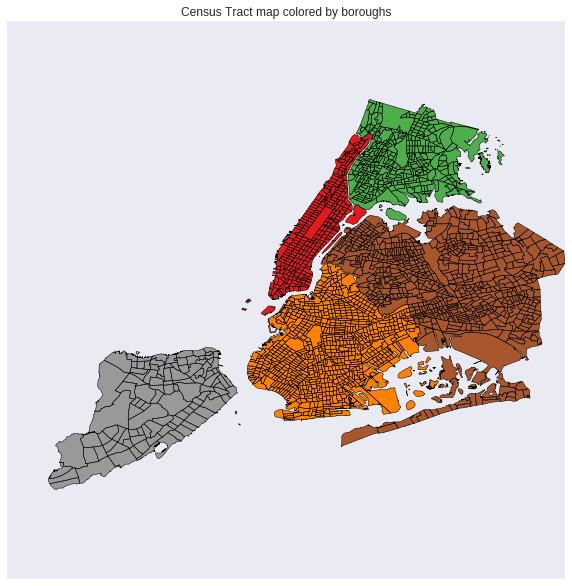

In [11]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

# Figure 1. This is a map of NYC split by Census Tract, with the boroughs highlighted via different colors.  The shape file used was indexed to the BoroCT2010 file.

### Map NYC Population density

#### Load Census Data for 2010

In [12]:
ct_data=DataFrame.from_csv("ACS_CT2010.csv")
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [13]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


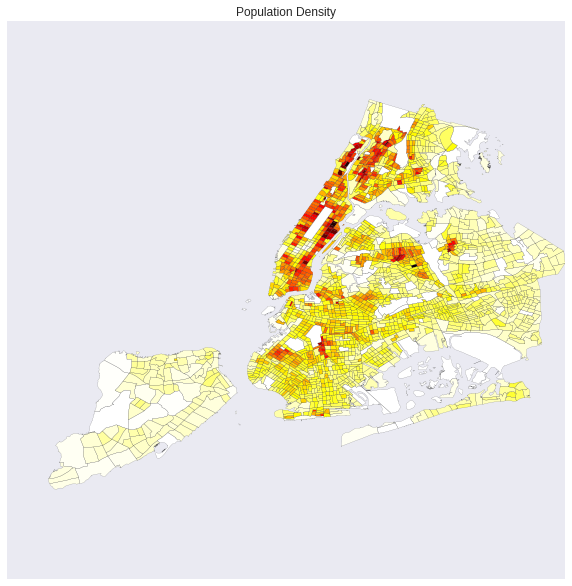

In [14]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

# Figure 2.  This is a "heat" map by density of NYC.  The darker the color, the denser the population.  Midtown Manhattan and the South Bronx are the most densely-populated neighborhoods.

## Explore CitiBike data

### Load CitiBike data

In [15]:
df_bike_monthly=DataFrame.from_csv('CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Create Data Frames seaparating stats for Summer and Winter Months - code / direction provided by
# Kelsey Reid / kdr276

# Summer Months DataFrame (April - September)
df_bike_summer = df_bike_monthly.iloc[[0,1,2,9,10,11,12,13,14,21,22,23,24,25,26,33,34,35], :]

# Winter Months DataFrame (October - March)
df_bike_winter = df_bike_monthly.iloc[[3,4,5,6,7,8,15,16,17,18,19,20,27,28,29,30,31,32], :]

### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

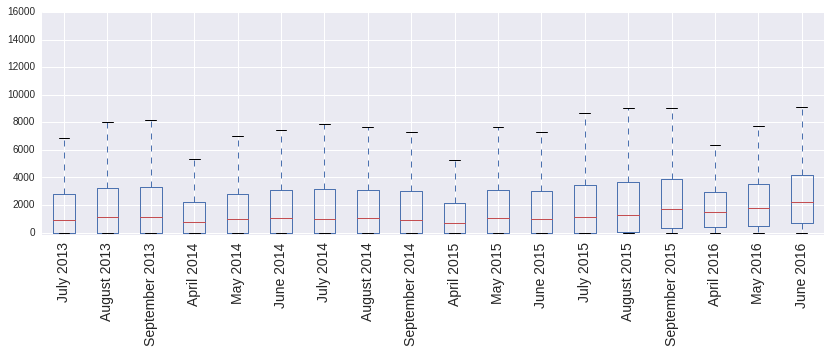

In [17]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_summer_=df_bike_summer.copy()
df_bike_summer_.index=df_bike_summer_.index.strftime("%B %Y")
df_bike_summer_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

# Figure 3.  This is a "box-and-whisker" plot of Citibike ridership for the summer months (April - September).  We observe seasonality by months (less so in the early summer months, e.g. April) as well as periodicity between the years.

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

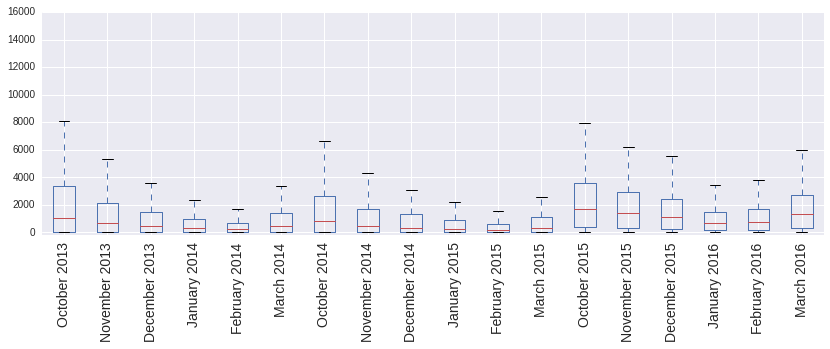

In [18]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_winter_=df_bike_winter.copy()
df_bike_winter_.index=df_bike_winter_.index.strftime("%B %Y")
df_bike_winter_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

# # Figure 4.  This is a "box-and-whisker" plot of Citibike ridership for the winter months (October - March).  We observe seasonality by months (less so in the "deep" winter months, e.g. January) as well as periodicity between the years.  There is less ridership as compared to the summer months.

#### Seasonal Decomposition

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


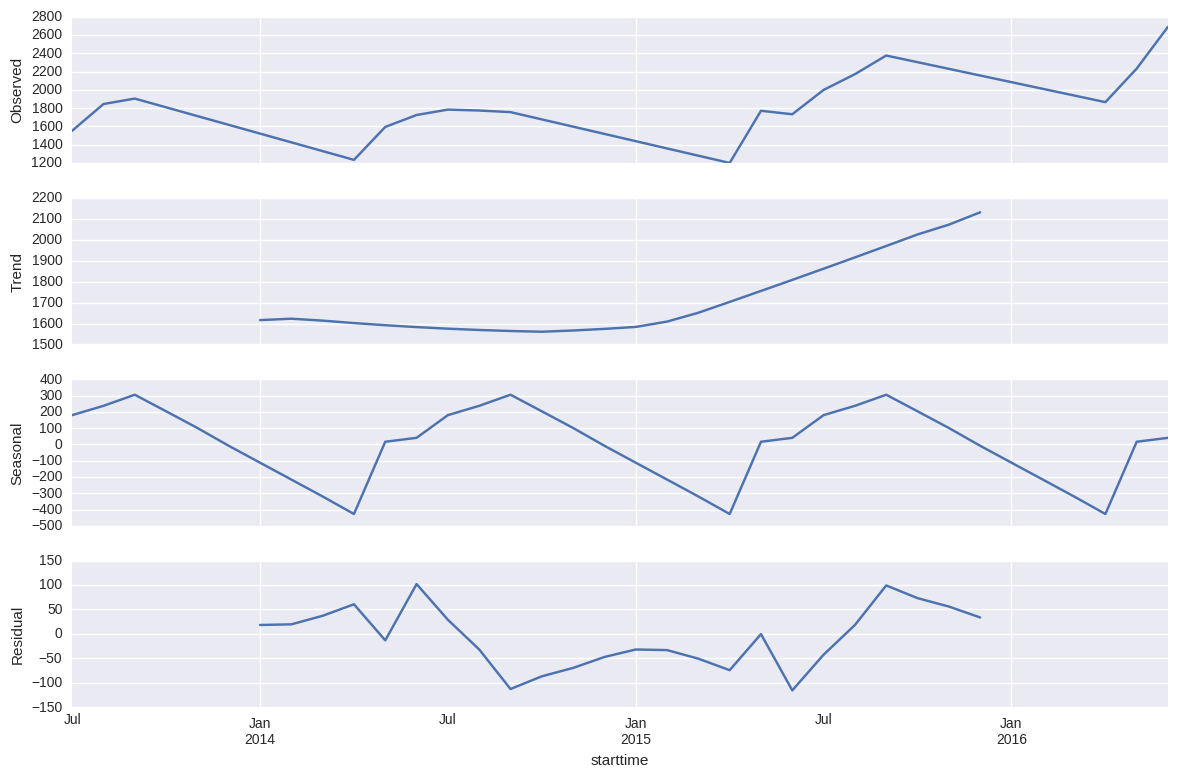

In [14]:
#Create a monthly time series of bike ride (Average of all citibike stations) - SUMMER MONTHS
df_new_S=df_bike_summer.mean(1).resample('M').mean()
df_new_S.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new_S.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

# Figure 5.  This is a season decomposition of the summer month Citibike data.  We observe seasonality (as seen previously), but also see a clear trend upwards in terms of total ridership.  This can be attributed to an expansion of available bikes/stations as well as more awareness of the service.

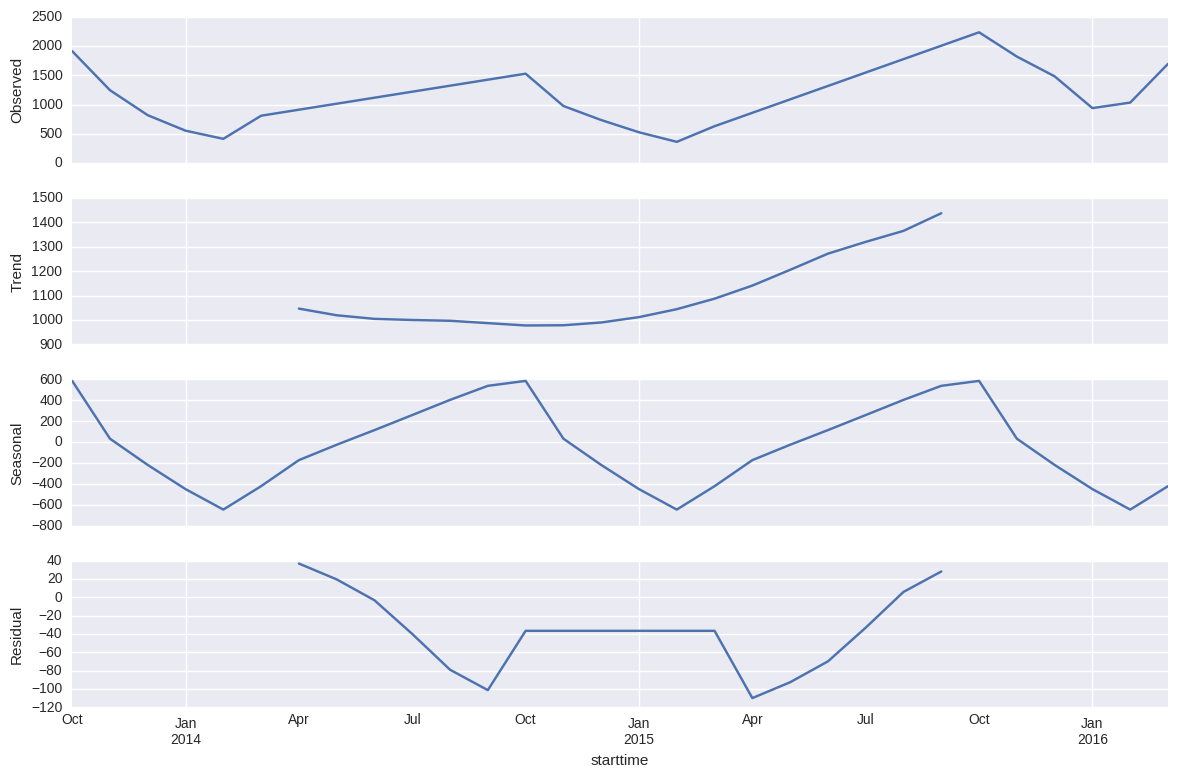

In [15]:
#Create a monthly time series of bike ride (Average of all citibike stations) - WINTER MONTHS
df_new_W=df_bike_winter.mean(1).resample('M').mean()
df_new_W.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new_W.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

# Figure 6.  This is a season decomposition of the winter month Citibike data.  As in Figure 5, we observe seasonality (as seen previously), but also see a clear trend upwards in terms of total ridership.  This can be attributed to an expansion of available bikes/stations as well as more awareness of the service.

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [19]:
station_id=DataFrame.from_csv("Station_id.csv")
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [20]:
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [21]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [22]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [23]:
### Create average monthly rides columns for summer and winter averages, as well as all months
station_id['Monthly_Avg'] = df_bike_monthly.sum()
station_id['Summer_Avg']=df_bike_summer.sum()
station_id['Winter_Avg']=df_bike_winter.sum()

In [24]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,Monthly_Avg,Summer_Avg,Winter_Avg
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308,42378,26930
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824,67646,35178
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525,169085,104440
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949,64084,37865
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044,116324,67720


### Add the monthly average rides to the CT shapefile 

In [25]:
temp=station_id[['Monthly_Avg', 'Summer_Avg', 'Winter_Avg']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAvg=ct_shape.join(temp)
ct_shape_MonthlyAvg.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


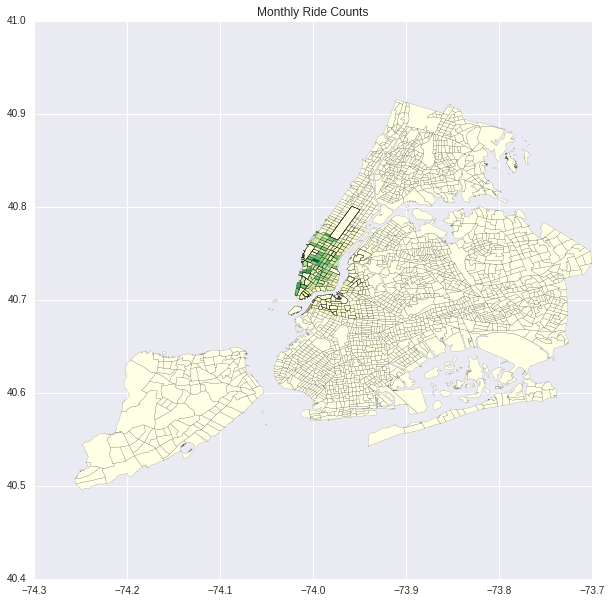

In [26]:
# Monthly Ride Counts Map
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAvg.plot(column='Monthly_Avg',colormap='YlGn',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

# Figure 7.  This is an NYC shape file (with Census Tracts) with monthly Citibike ride counts overlaid (by Citibike stations ID'd by lat/long coordinates).  The majority of the rides are concentrated in mid- to lower-Manhattan, with a smaller concentration in downtown Brooklyn.  This correlates with the actual areas in which Citibike stations exist.

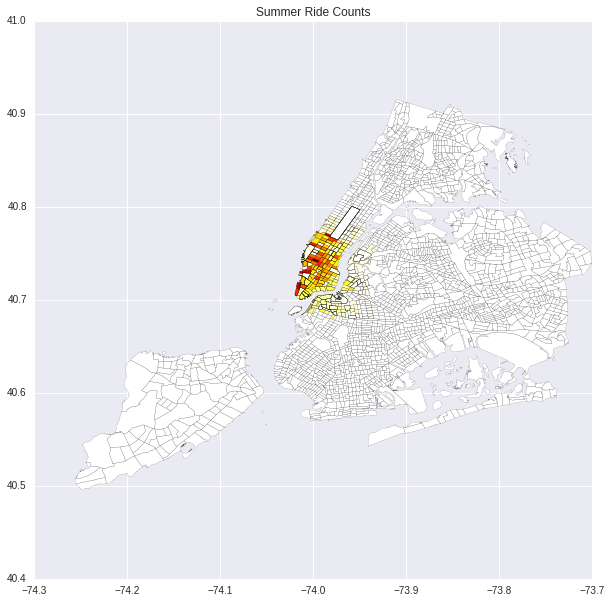

In [27]:
# Summer Ride Counts Map
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAvg.plot(column='Summer_Avg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ride Counts")

# Figure 8.  This is an NYC shape file (with Census Tracts) with summer Citibike ride counts overlaid (by Citibike stations ID'd by lat/long coordinates).  The majority of the rides are concentrated in mid- to lower-Manhattan, with a smaller concentration in downtown Brooklyn.  This correlates with the actual areas in which Citibike stations exist.

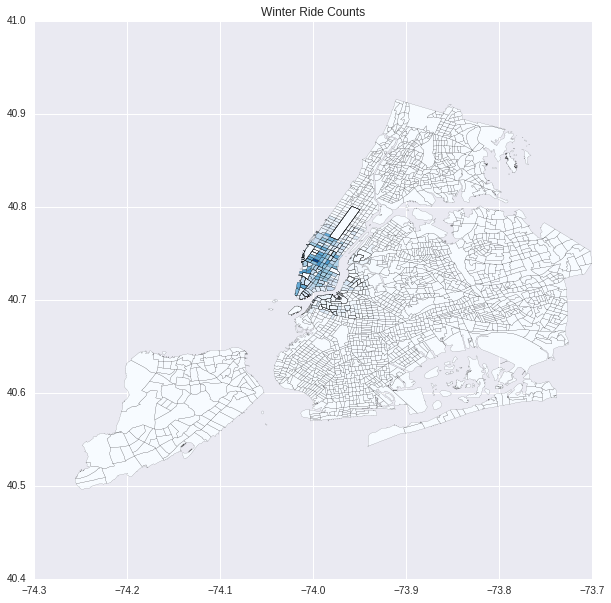

In [28]:
# Winter Ride Counts Map
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAvg.plot(column='Winter_Avg',colormap='Blues',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ride Counts")

# Figure 9.  This is an NYC shape file (with Census Tracts) with winter Citibike ride counts overlaid (by Citibike stations ID'd by lat/long coordinates).  The majority of the rides are concentrated in mid- to lower-Manhattan, with a smaller concentration in downtown Brooklyn.  This correlates with the actual areas in which Citibike stations exist.

### Removing the CTs that are out of zoom boundries

In [29]:
ct_shape_MonthlyAvg_Zoom=(ct_shape_MonthlyAvg[ct_shape_MonthlyAvg
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [30]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.Summer_Avg)  # Note: Length of Summer CTs == Length of Winter CTs

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

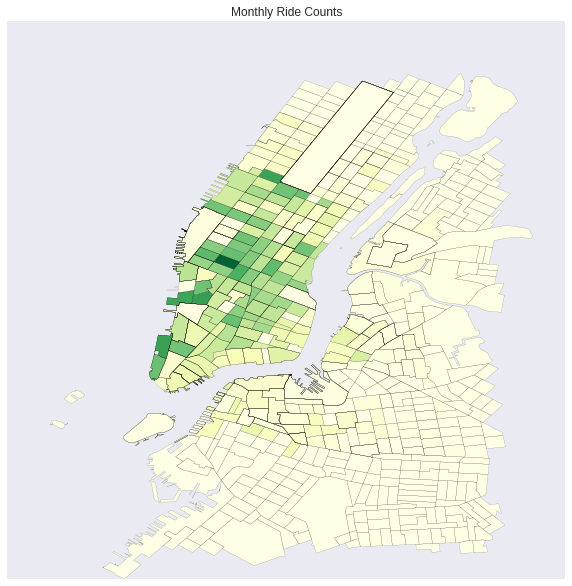

In [31]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAvg_Zoom.plot(column='Monthly_Avg',colormap='YlGn',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

# Figure 10.  This is an NYC shape file (with Census Tracts) with monthly Citibike ride counts overlaid (by Citibike stations ID'd by lat/long coordinates).  The map has been zoomed in (by lat/long coordinates) to focus on the areas of interest.  The majority of the rides are concentrated in mid- to lower-Manhattan, with a smaller concentration in downtown Brooklyn.  This correlates with the actual areas in which Citibike stations exist.

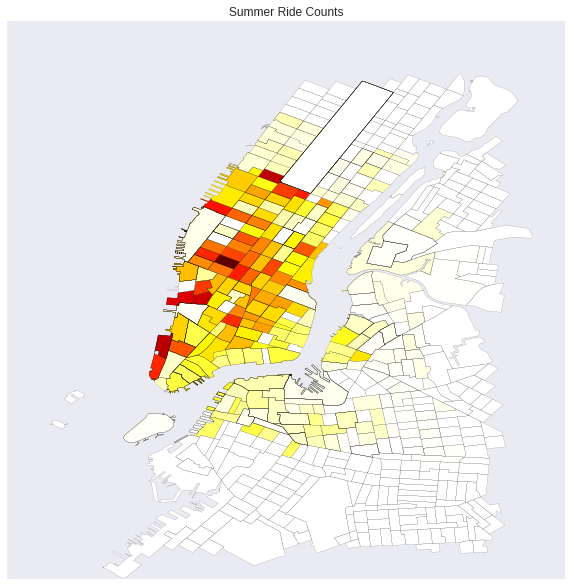

In [32]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAvg_Zoom.plot(column='Summer_Avg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ride Counts")

# Figure 11.  This is an NYC shape file (with Census Tracts) with summer Citibike ride counts overlaid (by Citibike stations ID'd by lat/long coordinates).  The map has been zoomed in (by lat/long coordinates) to focus on the areas of interest.  The majority of the rides are concentrated in mid- to lower-Manhattan, with a smaller concentration in downtown Brooklyn.  This correlates with the actual areas in which Citibike stations exist.

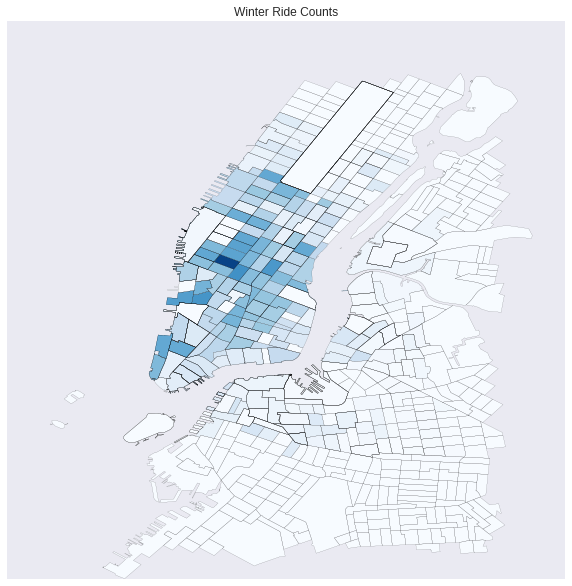

In [33]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAvg_Zoom.plot(column='Winter_Avg',colormap='Blues',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ride Counts")

# Figure 12.  This is an NYC shape file (with Census Tracts) with winter Citibike ride counts overlaid (by Citibike stations ID'd by lat/long coordinates).  The map has been zoomed in (by lat/long coordinates) to focus on the areas of interest.  The majority of the rides are concentrated in mid- to lower-Manhattan, with a smaller concentration in downtown Brooklyn.  This correlates with the actual areas in which Citibike stations exist.

### Export Shapefile CTs in the CitiBike Zone

In [34]:
path = "ct_shape_MonthlyAvg_Zoom.shp"
ct_shape_MonthlyAvg_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [35]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [36]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [37]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [38]:
Wmatrix, ids = qW_CT.full()

In [39]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [40]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [41]:
# Lags for Monthly, Summer, and Winter Rides:

# MONTHLY:

monthly_Ride = ct_shape_MonthlyAvg_Zoom.Monthly_Avg
monthly_Ride_Lag = ps.lag_spatial(qW_CT, monthly_Ride)


# SUMMER:

summer_Ride = ct_shape_MonthlyAvg_Zoom.Summer_Avg
summer_Ride_Lag = ps.lag_spatial(qW_CT, summer_Ride)

# WINTER:

winter_Ride = ct_shape_MonthlyAvg_Zoom.Winter_Avg
winter_Ride_Lag = ps.lag_spatial(qW_CT, winter_Ride)

#### Create Quantiles for maping

In [42]:
monthlyRideLagQ10 = ps.Quantiles(monthly_Ride_Lag, k = 10)
summerRideLagQ10 = ps.Quantiles(summer_Ride_Lag, k = 10)
winterRideLagQ10 = ps.Quantiles(winter_Ride_Lag, k = 10)

print (monthlyRideLagQ10)
print (summerRideLagQ10)
print (winterRideLagQ10)

                    Quantiles                    
 
  Lower                Upper                Count
             x[i] <=      0.000               140
     0.000 < x[i] <=    237.571                21
   237.571 < x[i] <=   4167.561                78
  4167.561 < x[i] <=  10026.857                80
 10026.857 < x[i] <=  17493.404                79
 17493.404 < x[i] <=  26977.053                80
 26977.053 < x[i] <=  58126.278                79
 58126.278 < x[i] <=  81788.042                80
 81788.042 < x[i] <=  96870.015                79
 96870.015 < x[i] <= 151983.357                80
                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               140
    0.000 < x[i] <=   137.571                21
  137.571 < x[i] <=  2404.850                78
 2404.850 < x[i] <=  5510.364                80
 5510.364 < x[i] <= 11145.782                79
11145.782 < x[i] <= 16953.467                80
16953.467 < 

#### Map the monthly rides lag

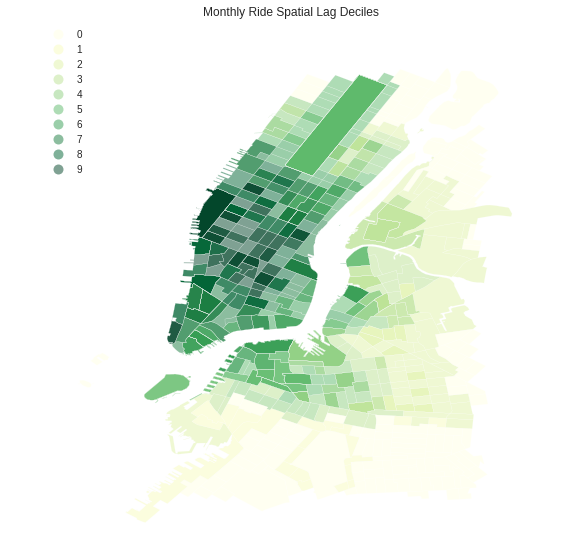

In [43]:
# MONTHLY
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAvg_Zoom.assign(cl=monthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='YlGn', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles")


# Figure 13. This is an NYC shape file (with Census Tracts) with monthly ride spacial lag data overlaid on top.  There is a heavy concentration of rider relationship in the mid- to lower-Manhattan areas (e.g. Hell's Kitchen being of particular note).  This shows that rides are noticeably more prevalent to and from these neighborhoods, with less emanating and ending from the upper Manhattan area and Brooklyn/Queens areas (downtown Brooklyn excluded).

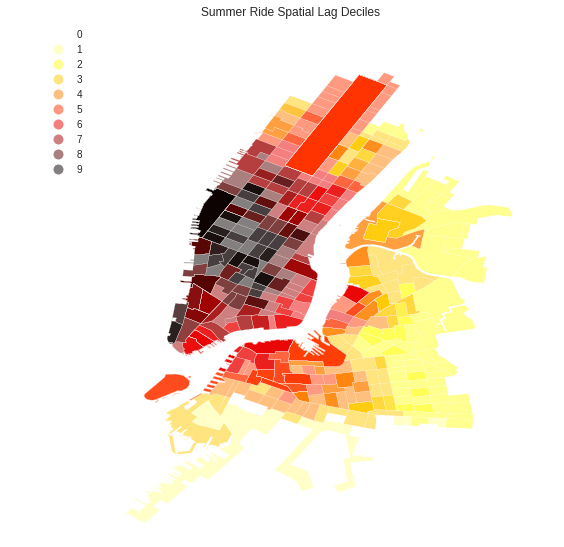

In [44]:
# SUMMER
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAvg_Zoom.assign(cl=summerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Ride Spatial Lag Deciles")

# Figure 14. This is an NYC shape file (with Census Tracts) with summer ride spacial lag data overlaid on top.  There is a heavy concentration of rider relationship in the mid- to lower-Manhattan areas (e.g. Hell's Kitchen being of particular note).  This shows that rides are noticeably more prevalent to and from these neighborhoods, with less emanating and ending from the upper Manhattan area and Brooklyn/Queens areas (downtown Brooklyn excluded).

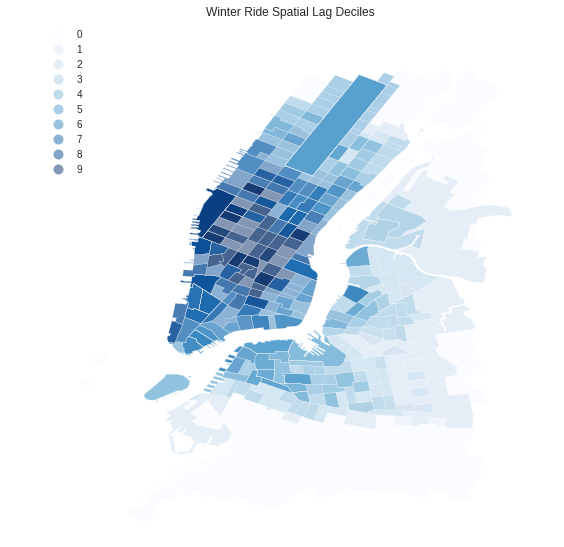

In [45]:
# WINTER
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAvg_Zoom.assign(cl=winterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='Blues', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Ride Spatial Lag Deciles")

# Figure 15. This is an NYC shape file (with Census Tracts) with winter ride spacial lag data overlaid on top.  There is a heavy concentration of rider relationship in the mid- to lower-Manhattan areas (e.g. Hell's Kitchen being of particular note).  This shows that rides are noticeably more prevalent to and from these neighborhoods, with less emanating and ending from the upper Manhattan area and Brooklyn/Queens areas (downtown Brooklyn excluded).

## Global  Spatial Autocorrelation

In [47]:
b1,a1 = np.polyfit(monthly_Ride, monthly_Ride_Lag, 1)  # all months
b2,a2 = np.polyfit(summer_Ride, summer_Ride_Lag, 1)  # summer
b3,a3 = np.polyfit(winter_Ride, winter_Ride_Lag, 1)  # winter

print (b1,a1) 
print (b2,a2) 
print (b3,a3) 

(0.65563669282948467, 12557.637062387894)
(0.64466687635049424, 8128.844260081486)
(0.65962241090192864, 4623.7815625116482)


### Moran Scatterplot

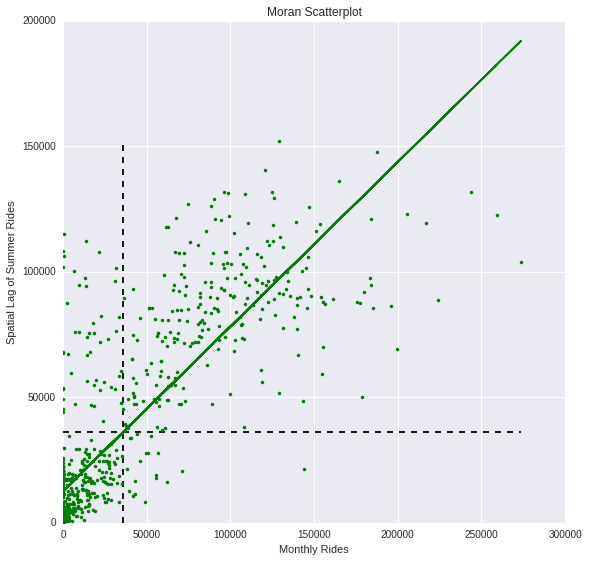

In [48]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(monthly_Ride, monthly_Ride_Lag, '.', color='green')

 # dashed vert at mean of the last year's PCI
plt.vlines(monthly_Ride.mean(), monthly_Ride_Lag.min(), monthly_Ride_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(monthly_Ride_Lag.mean(), monthly_Ride.min(), monthly_Ride.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(monthly_Ride, a1 + b1*monthly_Ride, 'g')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Monthly Rides')

# Figure 16.  This is a Moran scatterplot of the spatial lag of summer rides with monthly rides, using the slope and y-intercept calculated from the polyfit calculation.  Based on the scatter, we can see that there is a high positive correlation between the lag and rides, as most of the points are located within Q1 and Q3.

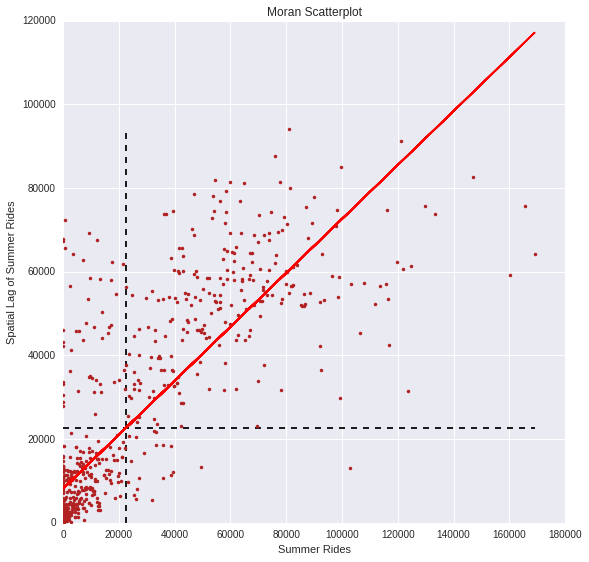

In [49]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(summer_Ride, summer_Ride_Lag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(summer_Ride.mean(), summer_Ride_Lag.min(), summer_Ride_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(summer_Ride_Lag.mean(), summer_Ride.min(), summer_Ride.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(summer_Ride, a2 + b2*summer_Ride, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Summer Rides')

# Figure 17.  This is a Moran scatterplot of the spatial lag of summer rides with summer rides, using the slope and y-intercept calculated from the polyfit calculation.  Based on the scatter, we can see that there is a high positive correlation between the lag and rides, as most of the points are located within Q1 and Q3.

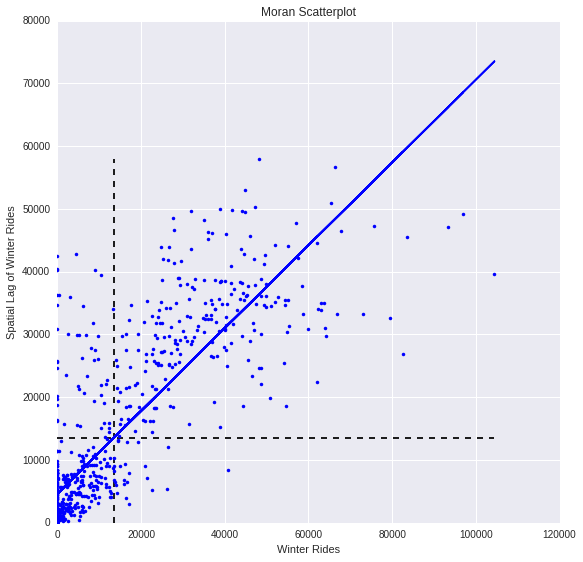

In [50]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(winter_Ride, winter_Ride_Lag, '.', color='blue')

 # dashed vert at mean of the last year's PCI
plt.vlines(winter_Ride.mean(), winter_Ride_Lag.min(), winter_Ride_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(winter_Ride_Lag.mean(), winter_Ride.min(), winter_Ride.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(winter_Ride, a3 + b3*winter_Ride, 'b')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')

# Figure 18.  This is a Moran scatterplot of the spatial lag of winter rides with winter rides, using the slope and y-intercept calculated from the polyfit calculation.  Based on the scatter, we can see that there is a high positive correlation between the lag and rides, as most of the points are located within Q1 and Q3.

### Moran's I

In [51]:
monthly_I = ps.Moran(monthly_Ride, qW_CT) # All Months
summer_I = ps.Moran(summer_Ride, qW_CT)   # Summer
winter_I = ps.Moran(winter_Ride, qW_CT)   # Winter

In [52]:
print(monthly_I.I, monthly_I.p_sim) # All Months
print(summer_I.I, summer_I.p_sim) # Summer
print(winter_I.I, winter_I.p_sim) # Winter

(0.65579332908409083, 0.001)
(0.64482518848460035, 0.001)
(0.65977718610668423, 0.001)


In [53]:
print (monthly_I.sim[0:10])  # All Months
print (summer_I.sim[0:10])  # Summer
print (winter_I.sim[0:10])  # Winter

[  4.08051568e-02   1.01713228e-03  -2.12468498e-02  -1.09743538e-03
   2.42578831e-02   8.03675798e-05   1.69777371e-02   4.68722703e-03
   1.16934900e-02   3.19437041e-02]
[ 0.00033542 -0.01170177 -0.00085189 -0.01997834 -0.00125208  0.00458766
  0.01486441  0.00880672 -0.00530324 -0.00845194]
[-0.00970212 -0.0032984   0.01628663 -0.00258353  0.00920301 -0.04236617
 -0.00614687 -0.0011692  -0.00053191 -0.0028834 ]


### KDEplot of all of the simulated points
the vertical line shows the observed value

In [54]:
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

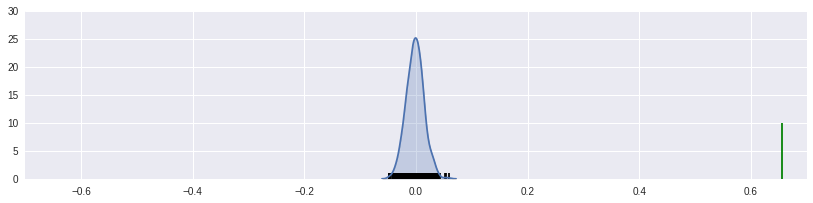

In [55]:

# KDE plots - All Months
sns.kdeplot(monthly_I.sim, shade=True)
plt.vlines(monthly_I.sim, 0, 1)
plt.vlines(monthly_I.I, 0, 10, 'g')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

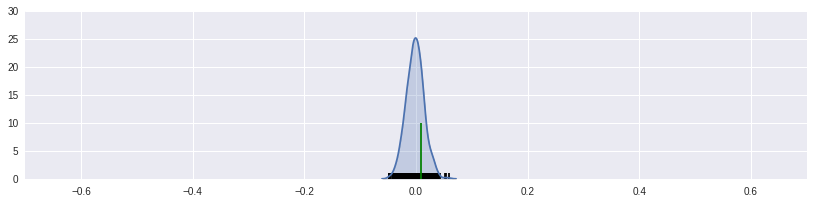

In [56]:
sns.kdeplot(monthly_I.sim, shade=True)
plt.vlines(monthly_I.sim, 0, 1)
plt.vlines(monthly_I.EI+.01, 0, 10, 'g')
plt.xlim([-.70, .70])

(-0.7, 0.7)

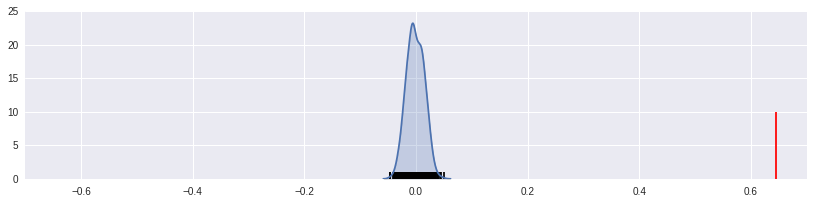

In [57]:
# KDE plots - Summer
sns.kdeplot(summer_I.sim, shade=True)
plt.vlines(summer_I.sim, 0, 1)
plt.vlines(summer_I.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

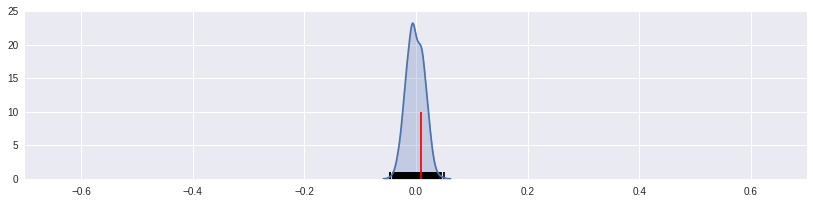

In [58]:
sns.kdeplot(summer_I.sim, shade=True)
plt.vlines(summer_I.sim, 0, 1)
plt.vlines(summer_I.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

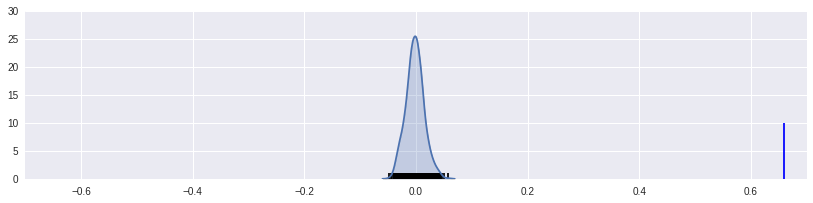

In [59]:
# KDE plots - Winter
sns.kdeplot(winter_I.sim, shade=True)
plt.vlines(winter_I.sim, 0, 1)
plt.vlines(winter_I.I, 0, 10, 'b')
plt.xlim([-.70, .70])

(-0.7, 0.7)

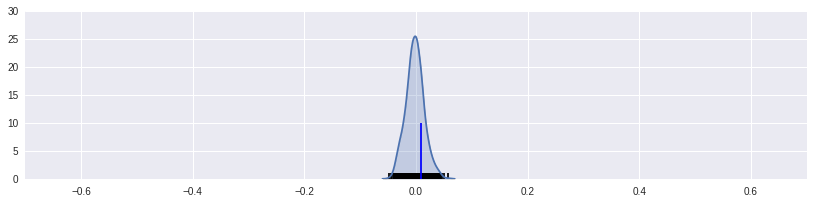

In [60]:
sns.kdeplot(winter_I.sim, shade=True)
plt.vlines(winter_I.sim, 0, 1)
plt.vlines(winter_I.EI+.01, 0, 10, 'b')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [61]:
LMo_MonthlyRide = ps.Moran_Local(monthly_Ride, qW_CT, permutations = 999) # All Months
LMo_SummerRide = ps.Moran_Local(summer_Ride, qW_CT, permutations=999) # Summer
LMo_WinterRide = ps.Moran_Local(winter_Ride, qW_CT, permutations=999) # Winter

In [62]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.25378156,  0.00285019,  0.00186   ,  0.00802061]),
 array([ 0.001,  0.185,  0.391,  0.413,  0.43 ]))

In [63]:
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.23934856,  0.01170042,  0.00166728,  0.021779  ]),
 array([ 0.001,  0.188,  0.362,  0.364,  0.38 ]))

In [64]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([-0.        , -0.27131052,  0.000345  , -0.00107098, -0.04975374]),
 array([ 0.001,  0.146,  0.5  ,  0.499,  0.446]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [65]:
sigs_A = monthly_Ride[LMo_MonthlyRide.p_sim <= .001]
W_sigs_A = monthly_Ride_Lag[LMo_MonthlyRide.p_sim <= .001]
insigs_A = monthly_Ride[LMo_MonthlyRide.p_sim > .001]
W_insigs_A = monthly_Ride_Lag[LMo_MonthlyRide.p_sim > .001]

In [66]:
sigs_S = summer_Ride[LMo_SummerRide.p_sim <= .001]
W_sigs_S = summer_Ride_Lag[LMo_SummerRide.p_sim <= .001]
insigs_S = summer_Ride[LMo_SummerRide.p_sim > .001]
W_insigs_S = summer_Ride_Lag[LMo_SummerRide.p_sim > .001]

In [67]:
sigs_W = winter_Ride[LMo_WinterRide.p_sim <= .001]
W_sigs_W = winter_Ride_Lag[LMo_WinterRide.p_sim <= .001]
insigs_W = winter_Ride[LMo_WinterRide.p_sim > .001]
W_insigs_W = winter_Ride_Lag[LMo_WinterRide.p_sim > .001]

### Plot Signficant LISA

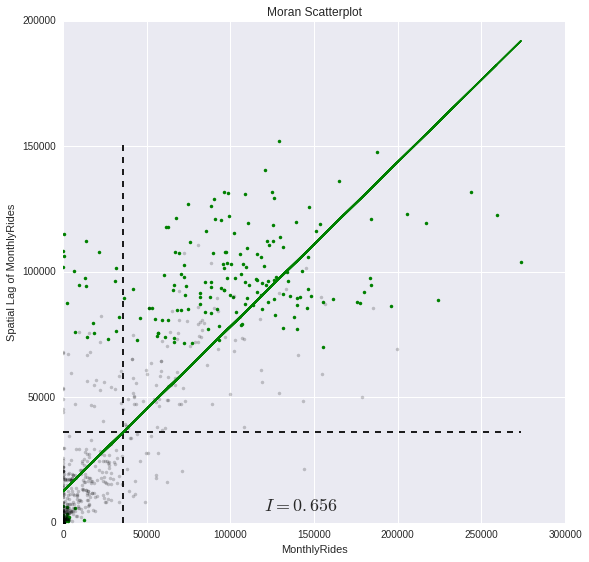

In [68]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_A, W_sigs_A, '.', color='green')
plt.plot(insigs_A, W_insigs_A, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % monthly_I.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(monthly_Ride.mean(), monthly_Ride_Lag.min(), monthly_Ride_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(monthly_Ride_Lag.mean(), monthly_Ride.min(), monthly_Ride.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(monthly_Ride, a1 + b1*monthly_Ride, 'g')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

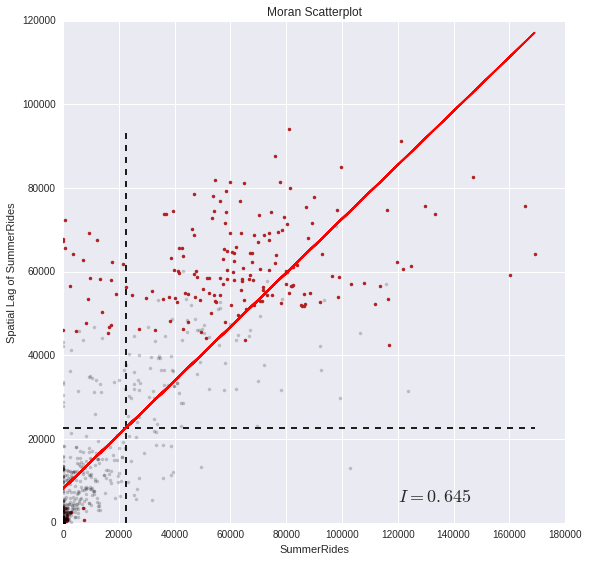

In [69]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_S, W_sigs_S, '.', color='firebrick')
plt.plot(insigs_S, W_insigs_S, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % summer_I.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(summer_Ride.mean(), summer_Ride_Lag.min(), summer_Ride_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(summer_Ride_Lag.mean(), summer_Ride.min(), summer_Ride.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(summer_Ride, a2 + b2*summer_Ride, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of SummerRides')
plt.xlabel('SummerRides')

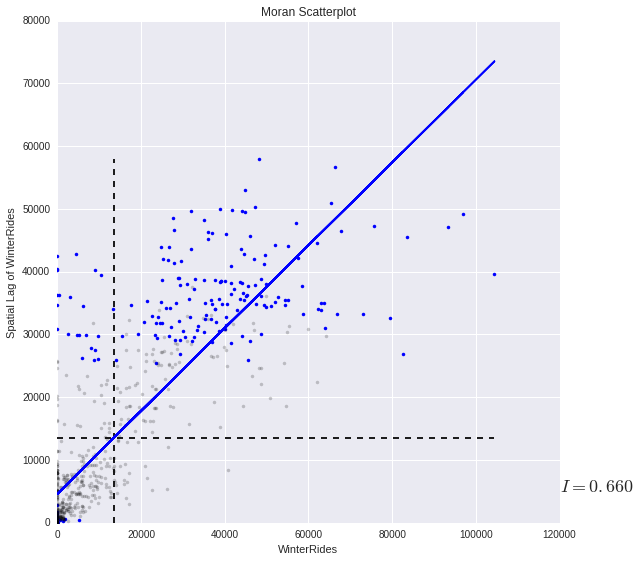

In [70]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_W, W_sigs_W, '.', color='blue')
plt.plot(insigs_W, W_insigs_W, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % winter_I.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(winter_Ride.mean(), winter_Ride_Lag.min(), winter_Ride_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(winter_Ride_Lag.mean(), winter_Ride.min(), winter_Ride.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(winter_Ride, a3 + b3*winter_Ride, 'b')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of WinterRides')
plt.xlabel('WinterRides')

### Hot and Cold spots 

In [71]:
sig_A = LMo_MonthlyRide.p_sim < 0.01
hotspots_A = LMo_MonthlyRide.q==1 * sig_A
coldspots_A = LMo_MonthlyRide.q==3 * sig_A
print "Number of Hotspots:", hotspots_A.sum()
print "Number of Coldspots:", coldspots_A.sum()

Number of Hotspots: 193
Number of Coldspots: 238


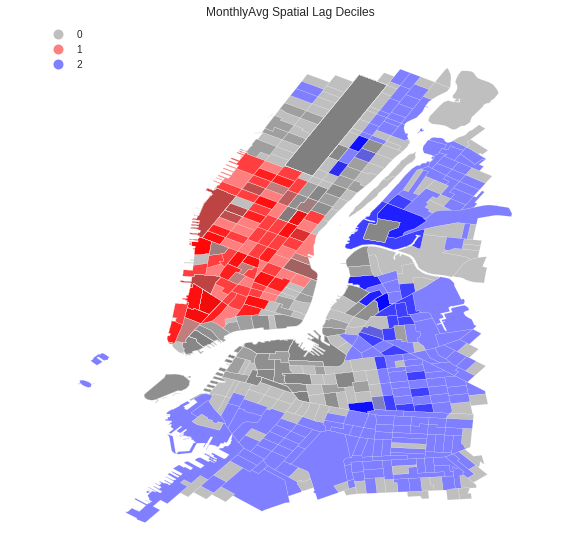

In [72]:
hcmap_A = colors.ListedColormap(['grey','red','blue'])
hotcold_A = hotspots_A*1 + coldspots_A*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAvg_Zoom.assign(cl=hotcold_A).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap_A, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAvg Spatial Lag Deciles")

In [73]:
sig_S = LMo_SummerRide.p_sim < 0.01
hotspots_S = LMo_SummerRide.q==1 * sig_S
coldspots_S = LMo_SummerRide.q==3 * sig_S
print "Number of Hotspots:", hotspots_S.sum()
print "Number of Coldspots:", coldspots_S.sum()

Number of Hotspots: 188
Number of Coldspots: 240


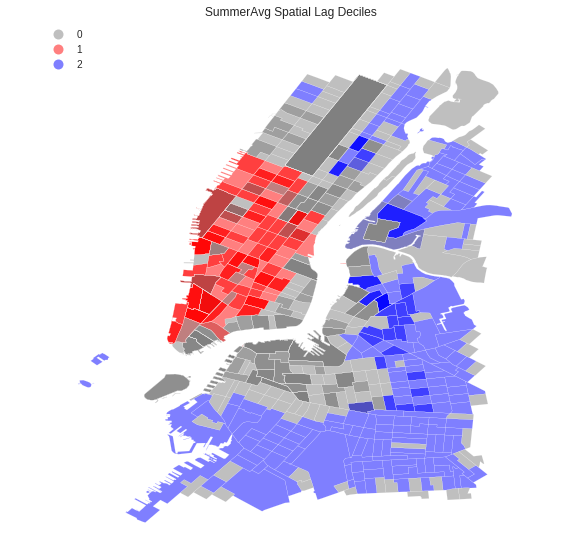

In [74]:
hcmap_S = colors.ListedColormap(['grey','red','blue'])
hotcold_S = hotspots_S*1 + coldspots_S*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAvg_Zoom.assign(cl=hotcold_S).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap_S, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("SummerAvg Spatial Lag Deciles")

In [75]:
sig_W = LMo_WinterRide.p_sim < 0.01
hotspots_W = LMo_SummerRide.q==1 * sig_W
coldspots_W = LMo_SummerRide.q==3 * sig_W
print "Number of Hotspots:", hotspots_W.sum()
print "Number of Coldspots:", coldspots_W.sum()

Number of Hotspots: 188
Number of Coldspots: 258


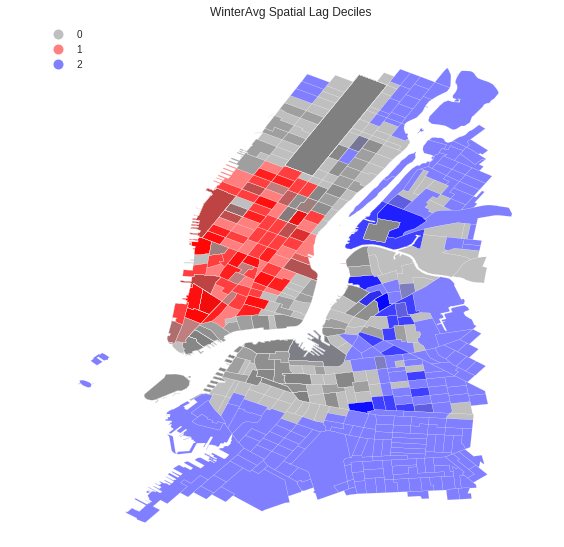

In [76]:
hcmap_W = colors.ListedColormap(['grey','red','blue'])
hotcold_W = hotspots_W*1 + coldspots_W*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAvg_Zoom.assign(cl=hotcold_W).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap_W, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("WinterAvg Spatial Lag Deciles")